# miχpods - TAO

In [ ]:
%load_ext watermark

import os

import cf_xarray
import dask
import dcpy
import distributed
import flox.xarray
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pump
from pump import mixpods

dask.config.set({"array.slicing.split_large_chunks": False})
mpl.rcParams["figure.dpi"] = 140 
xr.set_options(keep_attrs=True)

gcmdir = "/glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year/OUTPUT/"  # MITgcm output directory
stationdirname = gcmdir

%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.22.4
dcpy       : 0.1.dev360+g65bcf1a
xarray     : 2022.6.0rc0
dask       : 2022.6.1
flox       : 0.5.8.dev1+gc387edc
sys        : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]
hvplot     : 0.8.0
distributed: 2022.6.1
pandas     : 1.4.3
matplotlib : 3.5.2
pump       : 0.1
json       : 2.0.9
ipywidgets : 7.7.1
cf_xarray  : 0.7.2



In [ ]:
import ncar_jobqueue

if "client" in locals():
    client.close()
    del client
#if "cluster" in locals():
#    cluster.close()

#env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}

# cluster = distributed.LocalCluster(
#    n_workers=8,
#    threads_per_worker=1,
#    env=env
# )

if "cluster" in locals():
    del cluster

#cluster = ncar_jobqueue.NCARCluster(
#    project="NCGD0011",
#    scheduler_options=dict(dashboard_address=":9797"),
#)
# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )

import dask_jobqueue

cluster = dask_jobqueue.PBSCluster(
    cores=1, # The number of cores you want
    memory='23GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=23GB', # Specify resources
    project='ncgd0011', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
cluster.scale(jobs=4)

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36058 instead
  warnings.warn(


In [ ]:
client = distributed.Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/36058/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/36058/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:43433,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/36058/status,Total threads: 0
Started: Just now,Total memory: 0 B


/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:248: UserWarning: The specified Dask chunks separate the stored chunks along dimension "depth" starting at index 58. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:248: UserWarning: The specified Dask chunks separate the stored chunks along dimension "time" starting at index 139586. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:248: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


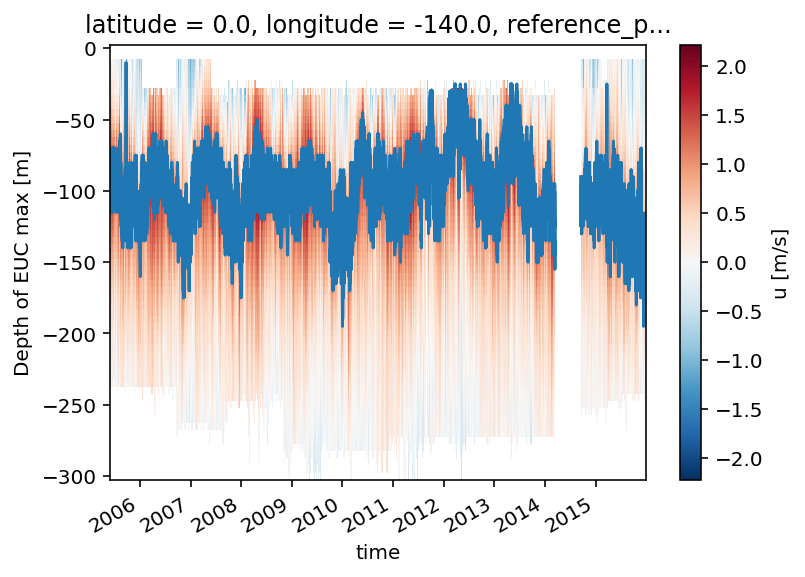

In [ ]:
tao_gridded = (
    xr.open_dataset(
        os.path.expanduser("~/work/pump/zarrs/tao-gridded-ancillary.zarr"), chunks="auto", engine="zarr"
    )
    .sel(longitude=-140, time=slice("2005-Jun", "2015"))
)
tao_gridded["depth"].attrs["axis"] = "Z"
# eucmax exists
tao_gridded.coords["eucmax"] = pump.calc.get_euc_max(tao_gridded.u.reset_coords(drop=True), kind="data")
#pump.calc.calc_reduced_shear(tao_gridded)
tao_gridded.coords["enso_transition"] = pump.obs.make_enso_transition_mask().reindex(time=tao_gridded.time, method="nearest")
tao_gridded.u.cf.plot()
tao_gridded.eucmax.plot()

In [ ]:
tao_gridded = (
    tao_gridded.update({
        "n2s2Tpdf": mixpods.pdf_N2S2(
            tao_gridded[["S2", "N2T"]].drop_vars(["shallowest", "zeuc"]).rename_vars({"N2T": "N2"})
        ).load(),
        "n2s2pdf": mixpods.pdf_N2S2(
            tao_gridded[["S2", "N2"]].drop_vars(["shallowest", "zeuc"])
        ).load()
    }
    )
)

## Labeling ENSO phase transitions

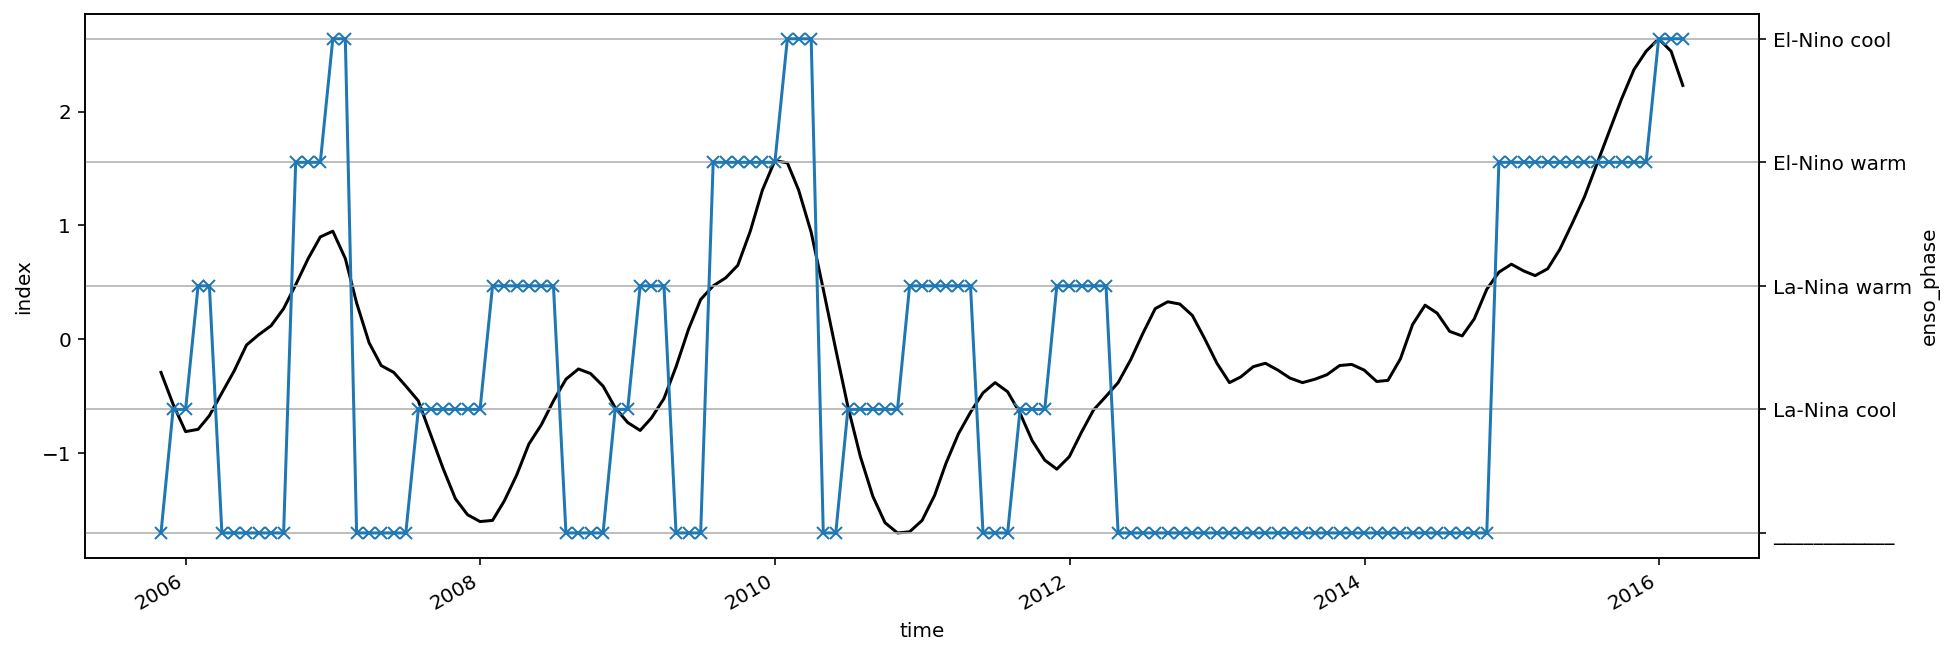

In [ ]:
pump.obs.process_oni().sel(time=slice("2005-Oct", "2016-Feb")).reset_coords(drop=True).plot.line(aspect=3, size=5, color='k')
pump.obs.make_enso_transition_mask().sel(time=slice("2005-Oct", "2016-Feb")).reset_coords(drop=True).plot.line(ax=plt.gca().twinx(), marker='x')
plt.grid(True, which="both", axis="both")

## N2 vs N2T

Lot more data with N2T

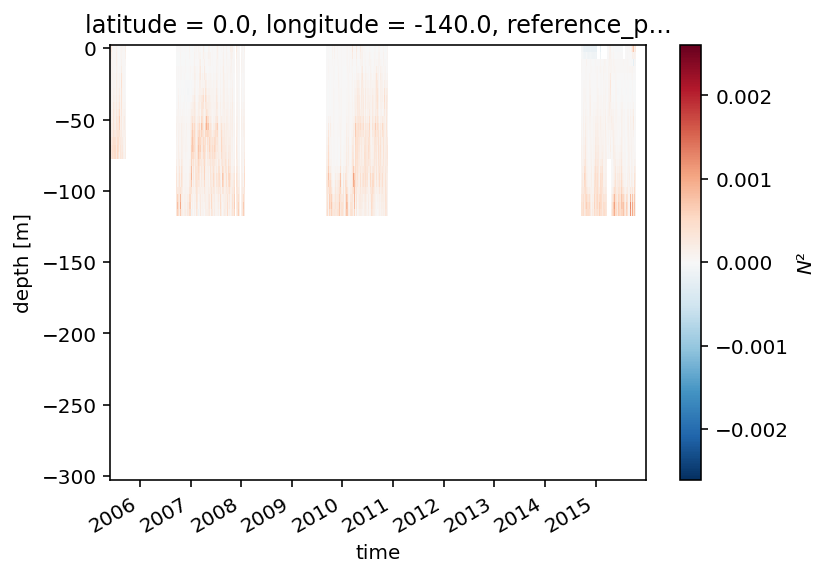

In [ ]:
tao_gridded.N2.cf.plot()

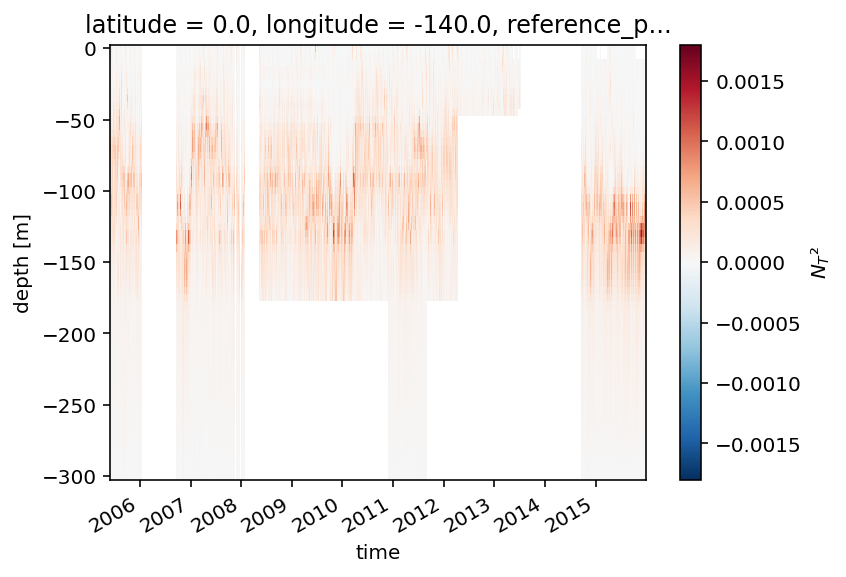

In [ ]:
tao_gridded.N2T.cf.plot()

## PDFs change 

(-4.5, -2.5)

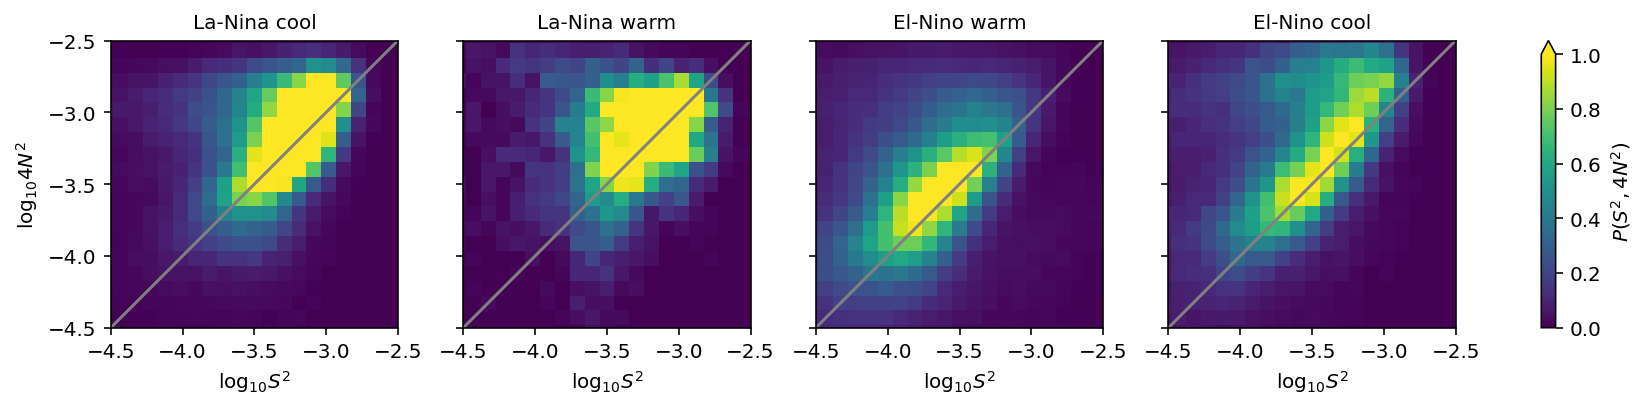

In [ ]:
fg = (
    tao_gridded.n2s2pdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .plot(vmax=1, col="enso_transition_phase")
)
fg.set_titles("{value}")
fg.map(dcpy.plots.line45)
fg.axes[0, 0].set_xlim((-4.5, -2.5))
fg.axes[0, 0].set_ylim((-4.5, -2.5))

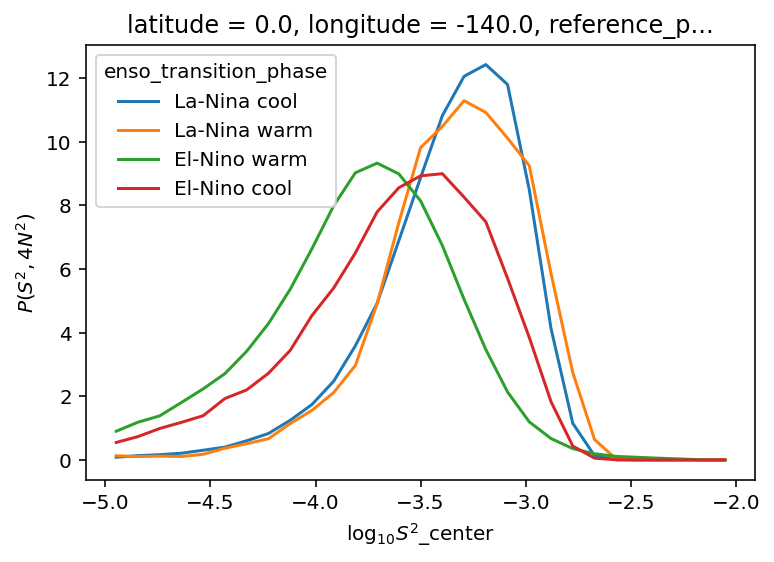

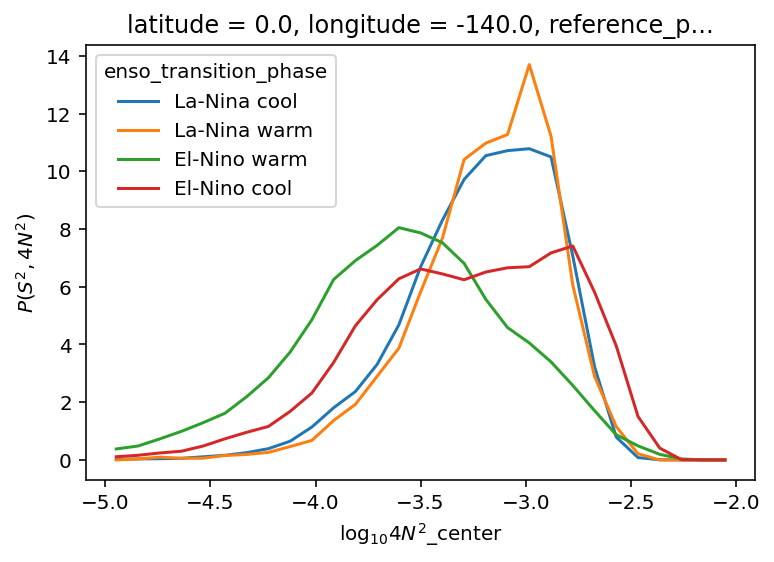

In [ ]:
(   
    tao_gridded.n2s2pdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .sum("N2_bins")
    .plot(hue="enso_transition_phase")
)
plt.figure()
(
    tao_gridded.n2s2pdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .sum("S2_bins")
    .plot(hue="enso_transition_phase")
)

(-4.5, -2.5)

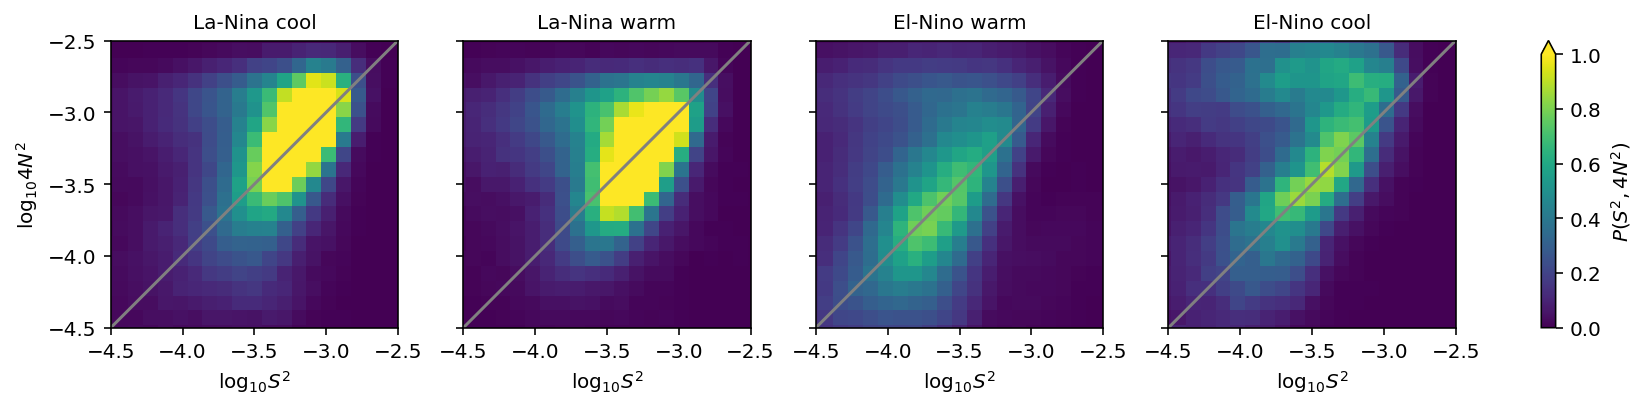

In [ ]:
fg = (
    tao_gridded.n2s2Tpdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .plot(vmax=1, col="enso_transition_phase")
)
fg.set_titles("{value}")
fg.map(dcpy.plots.line45)
fg.axes[0, 0].set_xlim((-4.5, -2.5))
fg.axes[0, 0].set_ylim((-4.5, -2.5))

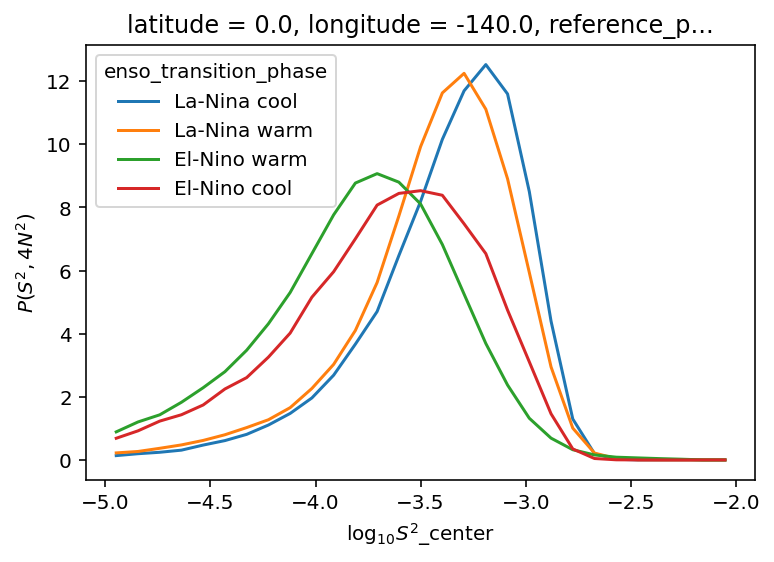

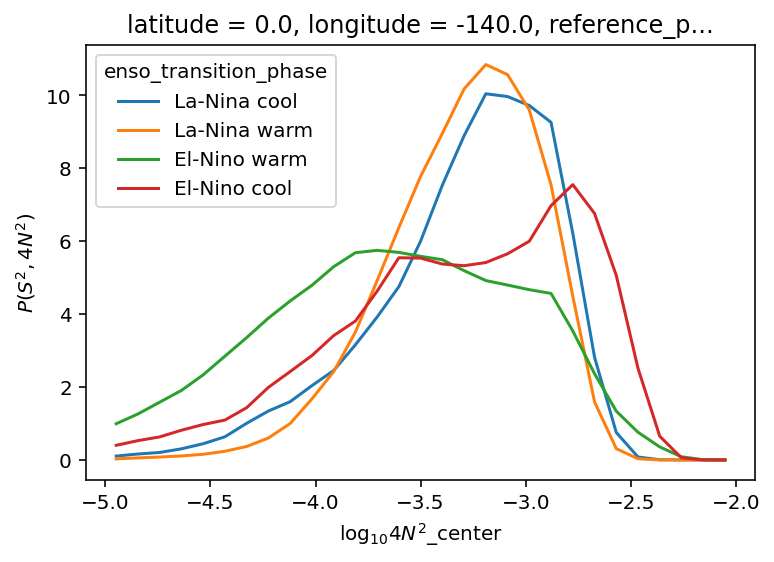

In [ ]:
(   
    tao_gridded.n2s2Tpdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .sum("N2_bins")
    .plot(hue="enso_transition_phase")
)
plt.figure()
(
    tao_gridded.n2s2Tpdf
    .sel(enso_transition_phase=["La-Nina cool", "La-Nina warm", "El-Nino warm", "El-Nino cool"])
    .sum("S2_bins")
    .plot(hue="enso_transition_phase")
)